In [10]:
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt

In [ ]:
# cities from UrClim excluding non-EU cities (i.e, Swiss cities)
all_cities = ['alicante', 'amsterdam', 'antwerp','athens', 'barcelona', 'bari', 'berlin',
            'bilbao', 'birmingham', 'bologna','bordeaux', 'brasov', 'bratislava','brussels', 'bucharest', 'budapest',
            'charleroi', 'cluj_napoca', 'cologne','copenhagen', 'debrecen','dublin', 'dusseldorf', 'edinburgh',
            'frankfurt_am_main', 'gdansk','genoa', 'ghent', 'glasgow','goteborg', 'graz', 'gyor',
            'hamburg', 'helsinki', 'klaipeda','kosice', 'krakow', 'leeds', 'leipzig','liege', 'lille', 'lisbon','ljubljana', 'lodz', 'london',
            'lyon', 'madrid','malaga', 'marseille', 'milan','miskolc', 'montpellier', 'munich','murcia', 'nantes', 'naples',
            'newcastle', 'nice',  'padua', 'palermo','palma_de_mallorca', 'paris', 'pecs',
            'porto', 'prague', 'riga', 'rome', 'rotterdam', 'sevilla',
            'sofia', 'split','stockholm', 'strasbourg', 'szeged','tallinn', 'tartu', 'thessaloniki',
            'toulouse', 'trieste','turin', 'utrecht', 'valencia','varna', 'vienna', 'vilnius',
            'warsaw', 'wroclaw', 'zagreb']

# exclude the cities that are not in Huang's mortality file
all_cities_mortality = all_cities.copy()
for city in ['alicante', 'birmingham', 'goteborg', 'lodz', 'newcastle', 'padua', 'palma_de_mallorca', 'tartu']:
    all_cities_mortality.remove(city)
    
# read the total monthly population per city (urbCLim domain sum) from files
df_night = pd.read_excel('C:\\Users\\glin\\Downloaded_data\\Results\\all_monthly_population.xlsx', sheet_name='night', index_col=0)
df_day = pd.read_excel('C:\\Users\\glin\\Downloaded_data\\Results\\all_monthly_population.xlsx', sheet_name='day', index_col=0)

# read the average temperature file (UrbClim domain)
df_temp = pd.read_excel('C:\\Users\\glin\\Downloaded_data\\Results\\monthly_avg_temp2011.xlsx', index_col=0)

# read the cities in the first quadrant (positive population in daytime and in winter)
df = pd.read_excel(f'C:\\Users\\glin\\Downloaded_data\\Results\\July_population_sum.xlsx', index_col=0)
df = df.drop(['alicante', 'birmingham', 'goteborg', 'lodz', 'newcastle', 'padua', 'palma_de_mallorca', 'tartu']) # exclude the cities with P_July higher than P_January
positive = df[df['diff'] > 0] # exclude the cities with higher P_night than P_day

# define the function for fitting
def cos_wave2(x, a, b, c):
    """
    Fit a cosine function to monthly population variation with constant period as 12, the peak/valley is around 6 
    """
    return a * np.cos(2*np.pi/12*(x+b)) + c


In [ ]:
## Fit the cosine wave to monthly population change for each city
# DataFrame to store the results
df_night_pars = pd.DataFrame(index=all_cities_mortality, columns=['a', 'b', 'c', 'r_squared'])
df_day_pars = pd.DataFrame(index=all_cities_mortality, columns=['a', 'b', 'c', 'r_squared'])
# fitting bounds
bounds=([-np.inf, -2, -np.inf], [np.inf, 0, np.inf]) 

for city in all_cities_mortality:
    try: 
        ## nighttime
        guess_c = np.mean(df_night.loc[city].to_numpy())
        guess_a = np.std(df_night.loc[city].to_numpy())
        p0 = [guess_a, 0, guess_c]
        params, cv = scipy.optimize.curve_fit(cos_wave2, np.arange(1,13,1), df_night.loc[city].to_numpy(), p0=p0, bounds=bounds)
        a, b, c = params
            
        # Calculate R-squared
        residuals = df_night.loc[city].to_numpy() - cos_wave2(np.arange(1,13,1), a, b, c)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((df_night.loc[city].to_numpy() - np.mean(df_night.loc[city].to_numpy()))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        df_night_pars.loc[city] = a, b, c, r_squared
        
        
        ## daytime
        guess_c = np.mean(df_day.loc[city].to_numpy())
        guess_a = np.std(df_night.loc[city].to_numpy())
        p0 = [guess_a, 0, guess_c]
        params, cv = scipy.optimize.curve_fit(cos_wave2, np.arange(1,13,1), df_day.loc[city].to_numpy(), p0=p0, bounds=bounds)
        a, b, c = params

        # Calculate R-squared
        residuals = df_day.loc[city].to_numpy() - cos_wave2(np.arange(1,13,1), a, b, c)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((df_day.loc[city].to_numpy() - np.mean(df_day.loc[city].to_numpy()))**2)
        r_squared = 1 - (ss_res / ss_tot)
        df_day_pars.loc[city] = a, b, c, r_squared
        
    except RuntimeError as error:
        print(f'{city}:{error}')
        
# with pd.ExcelWriter('path_to_file\\population_cosine_fitted_parameters2.xlsx') as writer:  
#     df_night_pars.to_excel(writer, sheet_name='night')
#     df_day_pars.to_excel(writer, sheet_name='day')

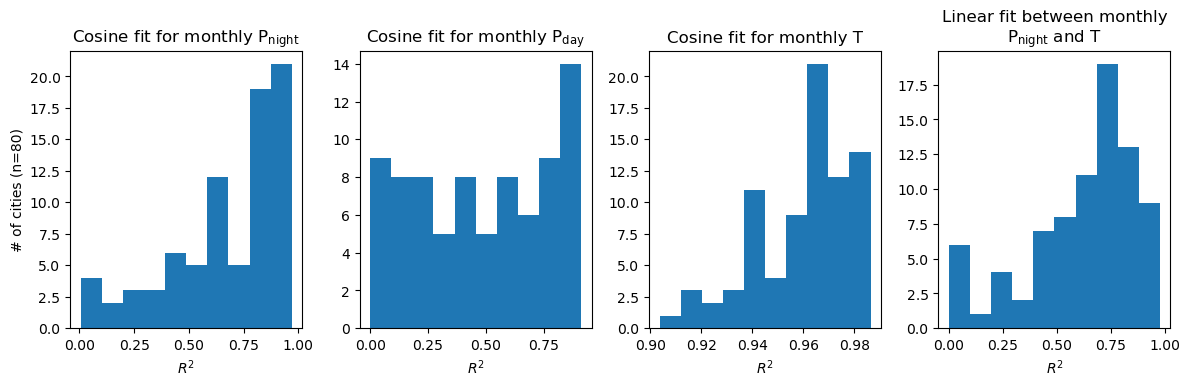

In [ ]:
# Linear fitting between monthly population and temperature
df_line = pd.DataFrame(index=all_cities_mortality, columns=['a', 'b', 'r', 'p'])
for j, city in enumerate(all_cities_mortality):
    # read the monthly population and temperature of the city
    p_array = df_night.loc[city]
    t_array = df_temp.loc[city]
    # population change is normalized with annual mean population
    a, b, r, p, _ = scipy.stats.linregress(t_array.astype(float)-t_array.mean(), 1000*(p_array.astype(float)-p_array.mean())/p_array.mean())
    df_line.loc[city, 'r'] = r**2
    df_line.loc[city, 'p'] = p
    df_line.loc[city, 'a'] = a
    df_line.loc[city, 'b'] = b
    
# cosine wave fitting of monthly temperature changes of each city    
df_temp_pars = pd.DataFrame(index=all_cities_mortality, columns=['a', 'b', 'c', 'r_squared'])
for city in all_cities_mortality:
    # fit temperature
    params, cv = scipy.optimize.curve_fit(cos_wave2, np.arange(1,13,1), df_temp.loc[city].to_numpy()) 
    a, b, c = params
    # Calculate R-squared
    residuals = df_temp.loc[city].to_numpy() - cos_wave2(np.arange(1,13,1), a, b, c)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((df_temp.loc[city].to_numpy() - np.mean(df_temp.loc[city].to_numpy()))**2)
    r_squared = 1 - (ss_res / ss_tot)
    df_temp_pars.loc[city] = a, b, c, r_squared

fig, ax = plt.subplots(1,4,figsize=(12,4))
ax[0].hist(df_night_pars['r_squared'])
ax[1].hist(df_day_pars['r_squared'])
ax[0].set_title(r'Cosine fit for monthly $\rm P_{night}$')
ax[1].set_title(r'Cosine fit for monthly $\rm P_{day}$')
ax[0].set_ylabel('# of cities (n=80)')
# ax[0].text(0.05,0.95, 'n=80', transform=ax[0].transAxes)
ax[2].hist(df_temp_pars['r_squared'])
ax[2].set_title('Cosine fit for monthly T')
ax[3].hist(df_line['r'])
ax[3].set_title('Linear fit between monthly\n' + r'$\rm P_{night}$ and T')
for axis in ax:
    axis.set_xlabel('$R^2$')
plt.tight_layout(pad=1.2)


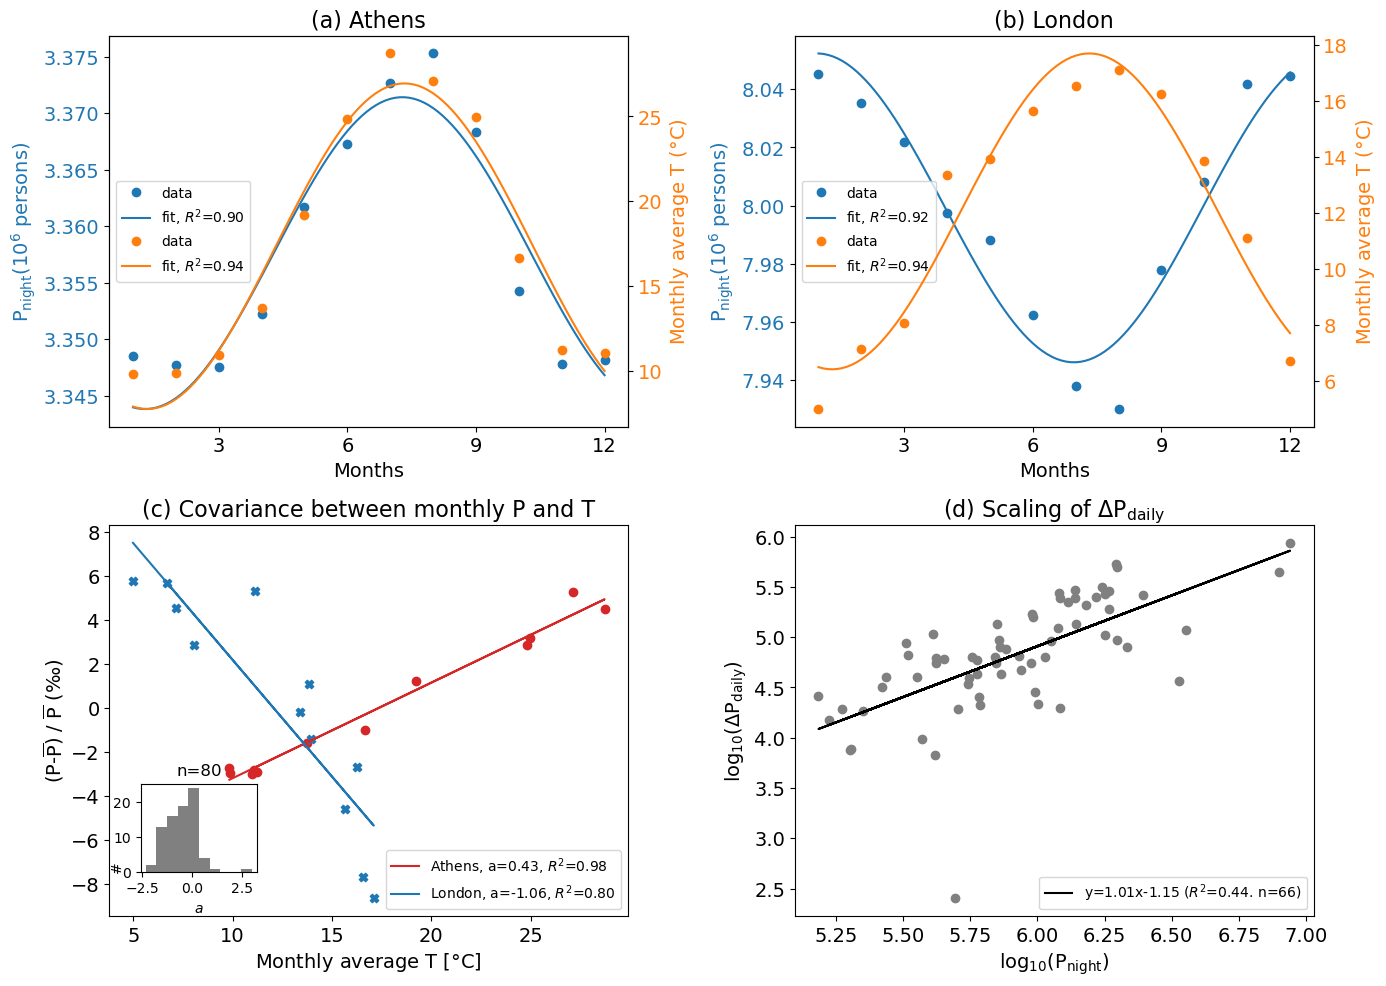

In [14]:
fig, ax = plt.subplots(2,2, figsize=(14,10))
cmap = plt.get_cmap("tab10")
####
city = 'athens'
color1 = cmap(0)
color2 = cmap(1)
color3 = 'tab:red'
color4 = 'tab:blue'
fontsize = 14
# population 
ax[0,0].set_title('(a) '+city.capitalize(), fontsize=16)
line1 = ax[0,0].plot(np.arange(1,13,1), df_night.loc[city]/1e6, 'o', label='data', color=color1)
a, b, c, r_squared = df_night_pars.loc[city]
line2 = ax[0,0].plot(np.linspace(1,12,100), cos_wave2(np.linspace(1,12,100), a, b, c)/1e6, label=f'fit, $R^2$={r_squared:.2f}')
ax[0,0].set_ylabel(r'P$_{\rm night}$(10$^6$ persons)', color=color1, fontsize=fontsize)
ax[0,0].set_xlabel('Months', fontsize=fontsize)
# temp 
ax_twin = ax[0,0].twinx()
line3 = ax_twin.plot(np.arange(1,13,1), df_temp.loc[city], 'o', color=color2, label='data')
a, b, c, r_squared = df_temp_pars.loc[city]
line4 = ax_twin.plot(np.linspace(1,12,100), cos_wave2(np.linspace(1,12,100), a, b, c), label=f'fit, $R^2$={r_squared:.2f}', color=color2)
ax_twin.set_ylabel('Monthly average T ($\N{DEGREE SIGN}$C)', color=color2, fontsize=fontsize)

lines = line1 + line2 + line3 + line4
labs = [l.get_label() for l in lines]
ax[0,0].legend(lines, labs, loc=6)
ax[0,0].set_xticks(np.arange(3,13,3),np.arange(3,13,3))
ax[0,0].tick_params(axis='y', labelcolor=color1)
ax_twin.tick_params(axis='y', labelcolor=color2, labelsize=fontsize)

# linear regression 
a, b, r, p, _ = scipy.stats.linregress(df_temp.loc[city], 1000*(df_night.loc[city]-df_night.loc[city].mean())/df_night.loc[city].mean())
ax[1,0].plot(df_temp.loc[city], a * df_temp.loc[city] + b, label=f'{city.capitalize()}, a={a:.2f}, $R^2$={r**2:.2f}', color=color3)
ax[1,0].scatter(df_temp.loc[city], 1000*(df_night.loc[city]-df_night.loc[city].mean())/df_night.loc[city].mean(), color=color3)

####
city = 'london'
ax[0,1].set_title('(b) '+city.capitalize(), fontsize=16)
# population
line1 = ax[0,1].plot(np.arange(1,13,1), df_night.loc[city]/1e6, 'o', label='data', color=color1)
a, b, c, r_squared = df_night_pars.loc[city]
line2 = ax[0,1].plot(np.linspace(1,12,100), cos_wave2(np.linspace(1,12,100), a, b, c)/1e6, label=f'fit, $R^2$={r_squared:.2f}')
ax[0,1].set_ylabel(r'P$_{\rm night}$(10$^6$ persons)', color=color1, fontsize=fontsize)
ax[0,1].set_xlabel('Months', fontsize=fontsize)
# temp 
ax_twin = ax[0,1].twinx()
line3 = ax_twin.plot(np.arange(1,13,1), df_temp.loc[city], 'o', color=color2, label='data')
a, b, c, r_squared = df_temp_pars.loc[city]
line4 = ax_twin.plot(np.linspace(1,12,100), cos_wave2(np.linspace(1,12,100), a, b, c), label=f'fit, $R^2$={r_squared:.2f}', color=color2)
ax_twin.set_ylabel('Monthly average T ($\N{DEGREE SIGN}$C)', color=color2, fontsize=fontsize)

lines = line1 + line2 + line3 + line4
labs = [l.get_label() for l in lines]
ax[0,1].legend(lines, labs, loc=6)
ax[0,1].set_xticks(np.arange(3,13,3),np.arange(3,13,3))
ax[0,1].tick_params(axis='y', labelcolor=color1)
ax_twin.tick_params(axis='y', labelcolor=color2, labelsize=fontsize)

# linear regression
a, b, r, p, _ = scipy.stats.linregress(df_temp.loc[city], 1000*(df_night.loc[city]-df_night.loc[city].mean())/df_night.loc[city].mean())
ax[1,0].plot(df_temp.loc[city], a * df_temp.loc[city] + b, label=f'{city.capitalize()}, a={a:.2f}, $R^2$={r**2:.2f}', color=color4 )
ax[1,0].scatter(df_temp.loc[city], 1000*(df_night.loc[city]-df_night.loc[city].mean())/df_night.loc[city].mean(), color=color4, marker='X')
ax[1,0].legend(loc=4, fontsize=10)
ax[1,0].set_xlabel('Monthly average T [$\N{DEGREE SIGN}$C]', fontsize=fontsize)
ax[1,0].set_ylabel(r'(P-$\overline{\rm P}$) / $\overline{\rm P}$' + f' (\u2030)', fontsize=fontsize)
# ax[1,0].axhline(1, color='gray', linestyle='--')

# scaling of delta P daily
a, b, r, p, _ = scipy.stats.linregress(np.log10(positive.night_pop), np.log10(positive['diff']))
ax[1,1].plot(np.log10(positive.night_pop), 
           a*np.log10(positive.night_pop)+b, label=f'y={a:.2f}x{b:.2f} ($R^2$={r**2:.2f}. n={len(positive)})', linestyle='-', color='k')
plot = ax[1,1].scatter(np.log10(positive.night_pop), np.log10(positive['diff']),color='gray')

ax[1,1].set_xlabel('log$_{10}$' + r'($\rm P_{night}$)', fontsize=fontsize)
ax[1,1].legend(loc=4, fontsize=10)
ax[1,1].set_ylabel('log$_{10}$' + r'($\rm \Delta P_{daily}$)', fontsize=fontsize)

ax_sub2 = ax[1,0].inset_axes([.06, .113, .225, .225])  
ax_sub2.hist(df_line.a, bins=10, color='gray')
ax_sub2.set_xlabel('$a$')
ax_sub2.set_ylabel('#', labelpad=-8, loc='bottom')
ax_sub2.set_title(f'n={len(df_line)}')

ax[1,0].set_title('(c) Covariance between monthly P and T', fontsize=16)
ax[1,1].set_title('(d) Scaling of ' r'$\rm \Delta P_{daily}$', fontsize=16)

for row in ax:
    for axis in row:
        axis.xaxis.set_tick_params(labelsize=fontsize)
        axis.yaxis.set_tick_params(labelsize=fontsize)
        
plt.tight_layout(pad=1.2)